# Fraud Detections
## Libraries

In [175]:
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import matplotlib.pyplot as plt

## Data Loading

In [176]:
def_feature = pd.read_csv("input/Xente_Variable_Definitions.csv")
data = pd.read_csv("input/training.csv")
X_test = pd.read_csv("input/test.csv")
sample_submission = pd.read_csv("input/sample_submission.csv")

## 1. Pre-processing

Let's give a look to our original data: 

In [177]:
data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


The following code shows that the following variables can be dropped as they have one unique value possible and therefore are not usefull for our model:
- `CurrencyCode`
- `CountryCode`

In [178]:
# Count the number of unique entries in each column
unique_counts = data.nunique()

# Select only columns with more than one unique entry
drop_cols = unique_counts[unique_counts == 1].index.tolist()
print("Dropping column with one unique values: ", drop_cols)

# Drop the selected columns
data = data.drop(columns=drop_cols)

# Count unique entries in each column
unique_counts = data.nunique()
print("\nResulting data:")
print(unique_counts)

Dropping column with one unique values:  ['CurrencyCode', 'CountryCode']

Resulting data:
TransactionId           95662
BatchId                 94809
AccountId                3633
SubscriptionId           3627
CustomerId               3742
ProviderId                  6
ProductId                  23
ProductCategory             9
ChannelId                   4
Amount                   1676
Value                    1517
TransactionStartTime    94556
PricingStrategy             4
FraudResult                 2
dtype: int64


In [179]:
# Get data types of each column
data_types = data.dtypes

# Print the data types
print(data_types)

TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object


After some observation, column with dtype `object` that contains the word `Id` in their name contains as entries strings of number with the following structure:  `ColumnNameId_X` where `X` is a numerical value.

We can therefore replace those string entry by their numeric value and then convert the column dtype into `int32`.

In [180]:
# Get a list of column names that contain the string "id" in their name
id_cols = data.filter(like='Id').columns.tolist()

# Print the list of column names
print("Converting columns with Id: ", id_cols)

# Remove column name prefix and convert to integer data type
data[id_cols] = data[id_cols].astype(str).apply(lambda x: x.str.replace(x.name + '_', '')).astype(int)

print(data.dtypes)

Converting columns with Id:  ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'ProviderId', 'ProductId', 'ChannelId']
TransactionId             int32
BatchId                   int32
AccountId                 int32
SubscriptionId            int32
CustomerId                int32
ProviderId                int32
ProductId                 int32
ProductCategory          object
ChannelId                 int32
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object


The data now looks like this: 

In [181]:
data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,76871,36123,3957,887,4406,6,10,airtime,3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,73770,15642,4841,3829,4406,4,6,financial_services,2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,26203,53941,4229,222,4683,6,1,airtime,3,500.0,500,2018-11-15T02:44:21Z,2,0
3,380,102363,648,2185,988,1,21,utility_bill,3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,28195,38780,4841,3829,988,4,6,financial_services,2,-644.0,644,2018-11-15T03:34:21Z,2,0


We can now focus on variable `ProductCategory` that contains 9 unique categories of transaction and convert it to numerical variable that contains value ranging from 1 to 9.

In [182]:
# Factorize the "ProductCategory" column
data['ProductCategory'] = pd.factorize(data['ProductCategory'])[0] + 1

# Convert the "ProductCategory" column to integer data type
data['ProductCategory'] = data['ProductCategory'].astype(int)

data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,76871,36123,3957,887,4406,6,10,1,3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,73770,15642,4841,3829,4406,4,6,2,2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,26203,53941,4229,222,4683,6,1,1,3,500.0,500,2018-11-15T02:44:21Z,2,0
3,380,102363,648,2185,988,1,21,3,3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,28195,38780,4841,3829,988,4,6,2,2,-644.0,644,2018-11-15T03:34:21Z,2,0


In [183]:
# Get data types of each column
data_types = data.dtypes

# Print the data types
print(data_types)

TransactionId             int32
BatchId                   int32
AccountId                 int32
SubscriptionId            int32
CustomerId                int32
ProviderId                int32
ProductId                 int32
ProductCategory           int32
ChannelId                 int32
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype: object


Let's now take a look to `TransactionStartTime` variable and start to extract year, month, date, hour, minute and second from the data.

In [184]:
# Extract year, month, day, hour, minute, and second from the "TransactionStartTime" column
data['year'] = pd.to_datetime(data['TransactionStartTime']).dt.year
data['month'] = pd.to_datetime(data['TransactionStartTime']).dt.month
data['day'] = pd.to_datetime(data['TransactionStartTime']).dt.day
data['hour'] = pd.to_datetime(data['TransactionStartTime']).dt.hour
data['minute'] = pd.to_datetime(data['TransactionStartTime']).dt.minute
data['second'] = pd.to_datetime(data['TransactionStartTime']).dt.second

# Removing TransactionStartTime column
data = data.drop(columns=['TransactionStartTime'])

data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,year,month,day,hour,minute,second
0,76871,36123,3957,887,4406,6,10,1,3,1000.0,1000,2,0,2018,11,15,2,18,49
1,73770,15642,4841,3829,4406,4,6,2,2,-20.0,20,2,0,2018,11,15,2,19,8
2,26203,53941,4229,222,4683,6,1,1,3,500.0,500,2,0,2018,11,15,2,44,21
3,380,102363,648,2185,988,1,21,3,3,20000.0,21800,2,0,2018,11,15,3,32,55
4,28195,38780,4841,3829,988,4,6,2,2,-644.0,644,2,0,2018,11,15,3,34,21


In [185]:
# Count unique entries in each column
unique_counts = data.nunique()
print("\nResulting data:")
print(unique_counts)


Resulting data:
TransactionId      95662
BatchId            94809
AccountId           3633
SubscriptionId      3627
CustomerId          3742
ProviderId             6
ProductId             23
ProductCategory        9
ChannelId              4
Amount              1676
Value               1517
PricingStrategy        4
FraudResult            2
year                   2
month                  4
day                   31
hour                  24
minute                60
second                60
dtype: int64


By looking at the unique value of our new date and time columns, we observe that we only have 4 month of data. So we can conclude that looking at the year or the month is not that conclusive for our model. 

Therefore we can drop those two variables.

In [186]:
drop_cols = ['year', 'month']
data = data.drop(columns=drop_cols)
data.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,PricingStrategy,FraudResult,day,hour,minute,second
0,76871,36123,3957,887,4406,6,10,1,3,1000.0,1000,2,0,15,2,18,49
1,73770,15642,4841,3829,4406,4,6,2,2,-20.0,20,2,0,15,2,19,8
2,26203,53941,4229,222,4683,6,1,1,3,500.0,500,2,0,15,2,44,21
3,380,102363,648,2185,988,1,21,3,3,20000.0,21800,2,0,15,3,32,55
4,28195,38780,4841,3829,988,4,6,2,2,-644.0,644,2,0,15,3,34,21


Now that we have a pretty clean data we can start to apply some feature engineering strategy

In [191]:
# Get data types of each column
data_types = data.dtypes

# Print the data types
print(data_types)

TransactionId        int32
BatchId              int32
AccountId            int32
SubscriptionId       int32
CustomerId           int32
ProviderId           int32
ProductId            int32
ProductCategory      int32
ChannelId            int32
Amount             float64
Value                int64
PricingStrategy      int64
FraudResult          int64
day                  int32
hour                 int32
minute               int32
second               int32
dtype: object


In [190]:
X = data.copy()
y = X.pop("FraudResult")
    
# All discrete features should have integer dtypes (double-check this before using MI!)
discrete_features = data.dtypes == int
print(discrete_features)

TransactionId       True
BatchId             True
AccountId           True
SubscriptionId      True
CustomerId          True
ProviderId          True
ProductId           True
ProductCategory     True
ChannelId           True
Amount             False
Value              False
PricingStrategy    False
FraudResult        False
day                 True
hour                True
minute              True
second              True
dtype: bool


In [192]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)

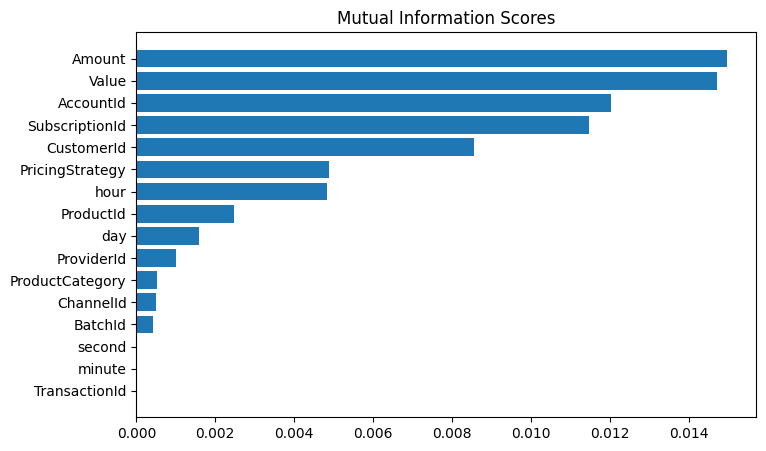

In [193]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

As we might expect, the high-scoring `value` and `amount` features exhibit a strong relationship with fraud.

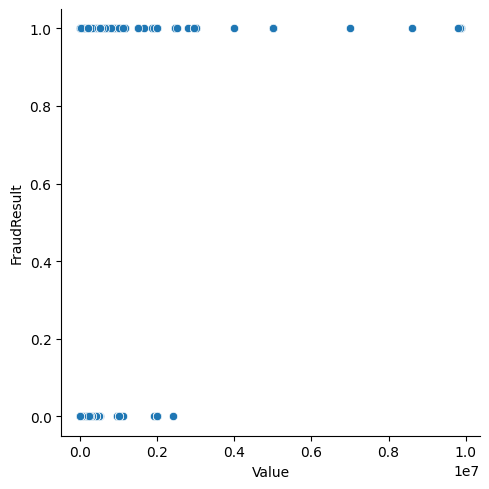

In [ ]:
import seaborn as sns
sns.relplot(x="Value", y="FraudResult", data=data);